# Implementación de regresión líneal manual con descenso de gradiente

In [4]:
#Importación de librerías
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Descarga de Datos

In [5]:
#Carga de datos
data = pd.read_csv('./Student_Performance.csv')

## Lectura del Dataset

In [6]:
data.head()  # Muestra todo el DataFrame

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [7]:
# Muestra un resumen del DataFrame
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Se puede ver que el número de entradas del dataset es igual que el número de datos no nulos en cada columna. Sin embargo, valores no nulos no son iguales que valores de 0. Aunque para este conjunto de datos podría ser posible que hayan columnas (a excepción de horas de sueño) con valores de 0, debería ser un caso extremadamente raro y hay que evaluar cuántas instancias con valores de 0 existen.

In [8]:
comunas_con_cero = (data == 0).any()
comunas_con_cero

Hours Studied                       False
Previous Scores                     False
Extracurricular Activities          False
Sleep Hours                         False
Sample Question Papers Practiced     True
Performance Index                   False
dtype: bool

Se puede ver que solo la columna con cantidad de preguntas de práctica tiene valores de 0, lo cual puede ser una ocurrencia común. Ahora se proceded a evaluar los datos duplicados. Los datos duplicados no son necesariamente malos siempre y cuando representen valores reales y formen parte de una distribución de datos real. Para este conjunto de datos no debería ser una ocurrencia extraña que hayan datos duplicados, sin embargo es importante saber qué tan frecuente se da la duplicación de datos

In [9]:
#Verificación de datos duplicados
data.duplicated().any()

np.True_

In [10]:
#Conteo de datos duplicados
print( f'{(data.duplicated().sum()/ len(data)) * 100 }% de los datos están duplicados')

1.27% de los datos están duplicados


Este valor es muy pequeño y no debería afectar la generalización del modelo, por lo cual se decide no eliminar los duplicados

Como la categoría de Extracurricular Activities indica que es de tipo objeto, se realizará un cambio de tipo a boleano númerico, donde 1 es Yes y 0 es No.

In [11]:
# Cambia los valores de "Yes" y "No" a 1 y 0, respectivamente
data["Extracurricular Activities"] = data["Extracurricular Activities"].map({"Yes": 1, "No": 0})

In [12]:
# Muestra estadísticas descriptivas del DataFrame
data.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


De aquí se puede ver que la mayoría de columnas tendrán una distribución uniforme ya que los valores de los percentiles están cerca de su respectivo nivel en cuanto al rango de datos dentro de cada columna. Por ejmplo, en la columna de "horas de estudio" se puede ver que el valor mayor es de 9 y el menor es de 1, por lo el punto medio sería 5 horas, y este es justo el valor de horas que estudian el percentil 50 de estudiantes. Este comportamiento se ve en la mayoría de columnas. 

Asumiendo que el índice de desempeño y las notas anteriores se miden de la misma forma, es interesante ver la distribución de percentil cambia bastanteEn el caso de las notas anteriores, se podría esperar una distribución con una inclinación mayor hacia la derecha que en la columna del índice de desempeño.

## Análisis de Características

A continuación se visualizarán los histogramas que nos ayudan a entender la distribución de los datos.

array([[<Axes: title={'center': 'Hours Studied'}>,
        <Axes: title={'center': 'Previous Scores'}>],
       [<Axes: title={'center': 'Extracurricular Activities'}>,
        <Axes: title={'center': 'Sleep Hours'}>],
       [<Axes: title={'center': 'Sample Question Papers Practiced'}>,
        <Axes: title={'center': 'Performance Index'}>]], dtype=object)

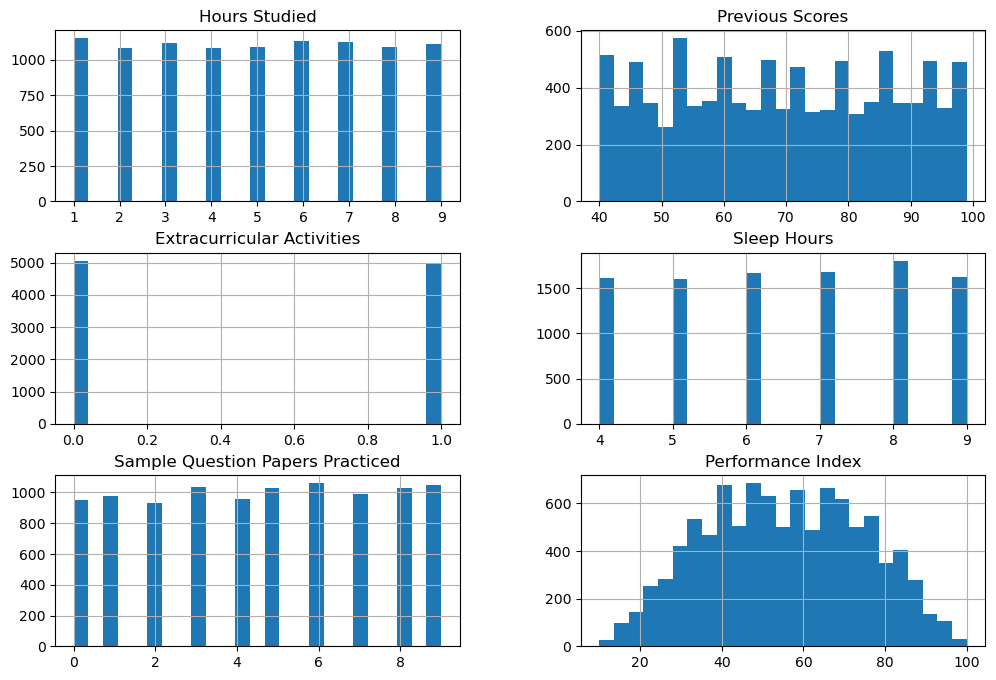

In [13]:
#histogramas de las variables numéricas de 15x10
data.hist(bins=25, figsize=(12, 8))

Los histogramas muestran una relación que se esperaba por el análisis de las estadísitcas. Se puede notar que la mayoría de las distribuciones son uniformes y no normales. Por su parte, el gráfico del índice de rendimiento muestra que se concentra en el rango de 40 a 80, lo cual resulta significantemente diferente de la distribución de las notas obtenidas anteriormente. Estos resultados podrían indicar que para la división del conjunto de datos para el entrenamiento, la columna que podría ayudar a estratificar los datos es la de performance index, lo cual no tendría mucho sentido porque esta columna son los valores a predecir.

Ahora se procede con la distribución de datos utilizando boxplots que expresan la distribución en términos de sus percentiles. Se omite la columna de Actividades extracurriculares ya que solo son 2 valores, de escala pequeña y su distribución queda clara con los histogramas

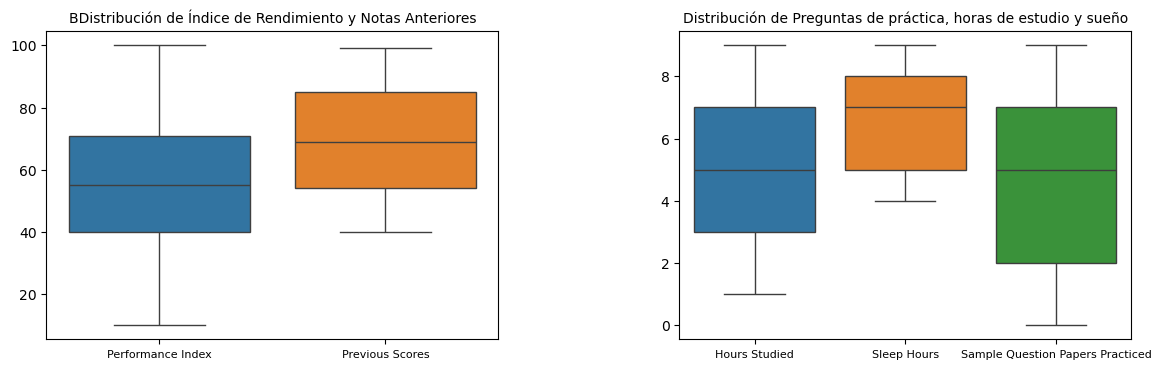

In [14]:
#Boxplot de las variables numéricas
plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
sns.boxplot(data[["Performance Index", "Previous Scores"]])
plt.title("BDistribución de Índice de Rendimiento y Notas Anteriores", fontsize=10)
plt.xticks(fontsize=8)
plt.subplot(1, 2, 2)
sns.boxplot(data[["Hours Studied", "Sleep Hours", "Sample Question Papers Practiced"]])
plt.title("Distribución de Preguntas de práctica, horas de estudio y sueño", fontsize=10)
plt.xticks(fontsize=8)
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

Se tienen las siguientes observaciones para cada columna:
<ul>
    <li>En el boxplot de horas estudiadas se aprecia una variabilidad media y no se observan indicios de sesgo.</li>
    <li>El boxplot de notas anteriores también muestra una variabilidad media sin evidencias de sesgo.</li>
    <li>En el caso de las horas de sueño, la caja es la más alta, lo que refleja una elevada variabilidad en los datos, con una distribución sesgada hacia la derecha.</li>
    <li>El boxplot de preguntas practicadas presenta la segunda caja más alta, indicando una alta variabilidad y un ligero sesgo a la izquierda.</li>
    <li>Finalmente, el boxplot del índice de rendimiento muestra una baja variabilidad y ausencia de sesgo.</li>
</ul>


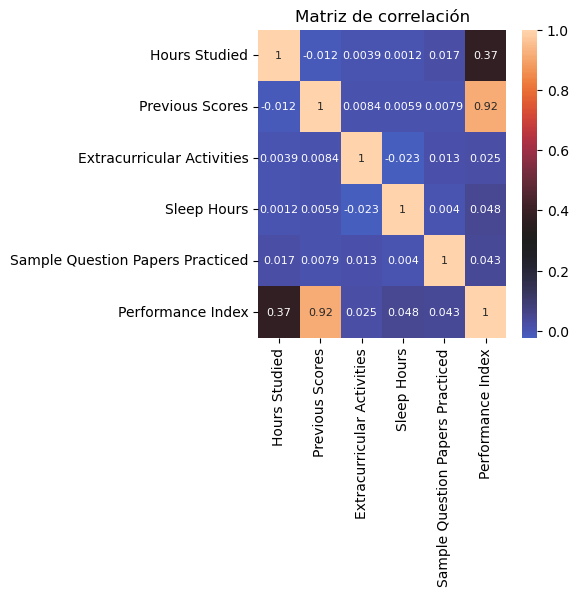

In [15]:
#matriz de correlación
plt.figure(figsize=(4,4))
sns.heatmap(data.corr(), annot=True, annot_kws={"size": 8}, center=.3)
plt.title("Matriz de correlación")
plt.show()

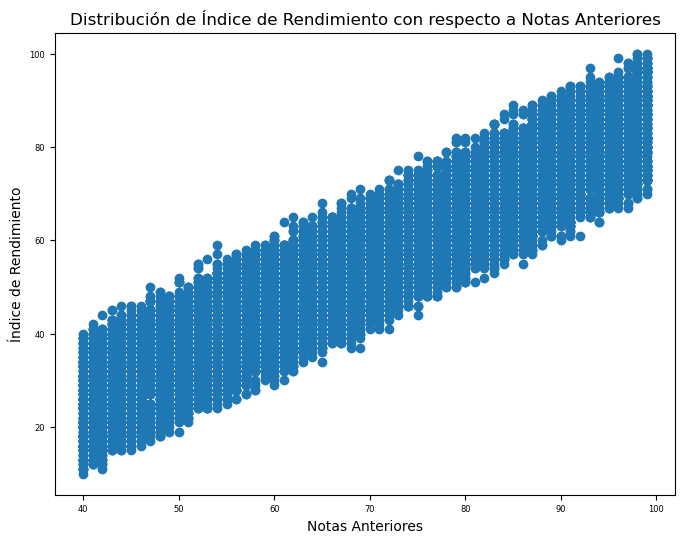

In [16]:
plt.figure(figsize=(8,6))
plt.scatter("Previous Scores", "Performance Index", data=data)
plt.title("Distribución de Índice de Rendimiento con respecto a Notas Anteriores")
plt.xlabel("Notas Anteriores")
plt.ylabel("Índice de Rendimiento")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

De este gráfico se puede corroborar visualmente la fuerte relación que existe entre estas 2 características

In [17]:
# Definir número de bins (rangos)
bins = 5
# Crear un diccionario para guardar los resultados
balance_summary = {}

for col in data.columns:
    binned = pd.cut(data[col], bins=bins)
    
    # Contar cuántos datos caen en cada rango y calcular porcentaje
    counts = binned.value_counts()
    percent = binned.value_counts(normalize=True) * 100
    # Guardar en el diccionario
    balance_summary[col] = pd.DataFrame({"count": counts, "proportion (%)": percent})

# Mostrar resultados
for col, df_summary in balance_summary.items():
    print(f"\nBalance por rangos de '{col}':")
    print(df_summary.sort_index())


Balance por rangos de 'Hours Studied':
               count  proportion (%)
Hours Studied                       
(0.992, 2.6]    2237           22.37
(2.6, 4.2]      2204           22.04
(4.2, 5.8]      1094           10.94
(5.8, 7.4]      2262           22.62
(7.4, 9.0]      2203           22.03

Balance por rangos de 'Previous Scores':
                 count  proportion (%)
Previous Scores                       
(39.941, 51.8]    1947           19.47
(51.8, 63.6]      2117           21.17
(63.6, 75.4]      1931           19.31
(75.4, 87.2]      2001           20.01
(87.2, 99.0]      2004           20.04

Balance por rangos de 'Extracurricular Activities':
                            count  proportion (%)
Extracurricular Activities                       
(-0.001, 0.2]                5052           50.52
(0.2, 0.4]                      0            0.00
(0.4, 0.6]                      0            0.00
(0.6, 0.8]                      0            0.00
(0.8, 1.0]                   4948

El análisis del balance de las variables continuas agrupadas en rangos muestra lo siguiente:

Hours Studied presenta una distribución relativamente uniforme en la mayoría de los rangos, aunque el intervalo intermedio (4.2–5.8 horas) concentra menos datos (10.8%), indicando un ligero desbalance.

Previous Scores está balanceado, con porcentajes muy similares en todos los rangos (19–21%).

Sleep Hours evidencia un desbalance, ya que el primer rango (3.99–5 horas) concentra un 32% de los datos, mientras que los otros rangos tienen aproximadamente entre 16 y 18%.

Sample Question Papers Practiced está balanceado, con distribución uniforme entre los rangos (19–21%).

Performance Index muestra un desbalance notable, con la mayoría de los datos concentrados en los rangos centrales (28–82), y solo alrededor del 8–9% en los rangos extremos.

En general, la mayoría de las variables presentan una distribución aceptablemente uniforme, excepto Sleep Hours y Performance Index, que requieren atención al interpretar los resultados de análisis estadísticos o de eficiencia, debido a la concentración de datos en rangos específicos.

In [18]:
#Detección de outliers con IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
# Umbrales para detectar outliers
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Crear máscara de outliers (True donde hay outlier)
outlier_mask = (data < lower) | (data > upper)

# Filtrar filas con al menos un outlier
outlier_rows = data[outlier_mask.any(axis=1)]

# Contar outliers por columna
outlier_counts = outlier_mask.sum()

# Mostrar resultados
print("Filas con al menos un outlier:")
print(outlier_rows)
print("\nConteo de outliers por columna:")
print(outlier_counts)

Filas con al menos un outlier:
Empty DataFrame
Columns: [Hours Studied, Previous Scores, Extracurricular Activities, Sleep Hours, Sample Question Papers Practiced, Performance Index]
Index: []

Conteo de outliers por columna:
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


El análisis de outliers basado en el rango intercuartílico (IQR) muestra que ninguna de las variables del dataset presenta valores atípicos. Esto indica que los datos son consistentes y no existen observaciones extremas que puedan distorsionar los resultados de análisis posteriores. En consecuencia, no es necesario realizar ningún tratamiento adicional sobre los datos.

## División de Dataset

In [19]:
def random_sampling(data, valid_ratio, test_ratio):
    indices = np.random.permutation(len(data))
    valid_set_size = int(len(data) * valid_ratio)
    test_set_size = int(len(data) * test_ratio)
    valid_indices = indices[:valid_set_size]
    test_indices = indices[valid_set_size: (valid_set_size + test_set_size)]
    train_indices = indices[(valid_set_size + test_set_size) :]
    return data.iloc[train_indices], data.iloc[test_indices], data.iloc[valid_indices]

In [20]:
train, test, valid = random_sampling(data, 0.1, 0.2)

In [21]:
print(f"Tamaño de conjunto de entrenamiento: {len(train)}\nTamaño de conjunto de validación: {len(valid)}\nTamaño de conjunto de prueba: {len(test)}")

Tamaño de conjunto de entrenamiento: 7000
Tamaño de conjunto de validación: 1000
Tamaño de conjunto de prueba: 2000


In [22]:
data.loc[:, "cat_performance"] = pd.cut(data["Performance Index"], bins=[0, 20, 40, 60, 80, 100], labels=[1, 2, 3, 4, 5])

In [23]:
percent = data["cat_performance"].value_counts()
percent

cat_performance
3    3316
4    3052
2    2294
5    1070
1     268
Name: count, dtype: int64

In [24]:
def stratified_random_sampling(data, feature_name, valid_ratio, test_ratio, bin_labels):
    valid_set_size = len(data) * valid_ratio
    test_set_size = len(data) * test_ratio
    
    train_indices = []
    valid_indices = []
    test_indices = []
    
    for label in bin_labels:
        category_indices = data[data[feature_name] == label].index.values
        
        randomized_category_indices = np.random.permutation(category_indices)

        valid_category_size = int(valid_ratio * len(randomized_category_indices))
        test_category_size = int(test_ratio * len(randomized_category_indices))
        
        valid_end = valid_category_size
        test_end = valid_category_size + test_category_size
        
        valid_indices.extend(randomized_category_indices[:valid_end])
        test_indices.extend(randomized_category_indices[valid_end: test_end])
        train_indices.extend(randomized_category_indices[test_end:])

    valid_indices = np.array(valid_indices)
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)
    
    return data.iloc[train_indices], data.iloc[valid_indices], data.iloc[test_indices]

In [25]:
train_set, valid_set, test_set = stratified_random_sampling(data, "cat_performance", 0.15, 0.15, [1,2,3,4,5])

In [26]:
assert (len(train_set) + len(valid_set) + len(test_set)) == len(data)

## Regresión Lineal

In [27]:
# Selección de features (todas excepto el target)
X_train = train_set.drop(columns=["Performance Index", "cat_performance"]).values
X_valid = valid_set.drop(columns=["Performance Index", "cat_performance"]).values
X_test = test_set.drop(columns=["Performance Index", "cat_performance"]).values
# Target
y_train = train_set["Performance Index"].values.reshape(-1, 1)  # columna vertical
y_valid = valid_set["Performance Index"].values.reshape(-1, 1)  # columna vertical
y_test = test_set["Performance Index"].values.reshape(-1, 1)  # columna vertical


In [28]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_norm = (X_train - mean) / std
X_valid_norm = (X_valid - mean) / std
X_test_norm = (X_test - mean) / std

# Número de muestras
m1 = X_train.shape[0]
m2 = X_valid.shape[0]
m3 = X_valid.shape[0]
# Agregar columna de 1s para el término independiente
X_train_norm = np.hstack([np.ones((m1, 1)), X_train_norm])
X_valid_norm = np.hstack([np.ones((m2, 1)), X_valid_norm])
X_test_norm = np.hstack([np.ones((m3, 1)), X_test_norm])

In [29]:
print("Shape de X (features):", X_train_norm.shape)
print("Shape de y (target):", y_train.shape)

Shape de X (features): (7004, 6)
Shape de y (target): (7004, 1)


Disminuir el Alfa y Aumentar las Iteraciones nos permitira encontrar un MSE mucho mas preciso, se utiliza por el momento alfa 0.0001 y 1000 iteraciones

In [30]:
#Función de Costo (MSE)
def compute_mse(X, y, theta):
    m = len(y)
    y_pred = X.dot(theta)
    mse = (1/m) * np.sum((y_pred - y)**2)
    return mse

### Batch GD

In [31]:
#Implementación del Decenso Gradiente
def train(X, y, X_valid, y_valid, alpha=0.0001, n_iter=1000):
    train_mse_history = []
    valid_mse_history = []
    
    n_features = X.shape[1]
    m = X.shape[0]
    theta = np.zeros((n_features, 1)) # Inicialización de pesos

    for i in range(n_iter):
        y_pred = X.dot(theta)# Predicciones
        y_pred_valid = X_valid.dot(theta)
        
        grad = (2/m) * X.T.dot(y_pred - y)# Gradiente
        theta = theta - alpha * grad# Actualizar pesos
        
        train_mse = compute_mse(X, y, theta)# Guardar MSE
        valid_mse = compute_mse(X_valid, y_valid, theta)
        train_mse_history.append(train_mse)
        valid_mse_history.append(valid_mse)
        
        # Imprimir cada 100 iteraciones
        if i % 100 == 0:
            print(f"Iteración {i}, MSE Entrenamiento: {train_mse:.4f}")
            print(f"Iteración {i}, MSE Validación: {valid_mse:.4f}")

    return theta, train_mse_history, valid_mse_history


In [33]:
theta, train_mse_history, valid_mse_history = train(X_train_norm, y_train, X_valid_norm, y_valid, alpha=0.005, n_iter=1000)

Iteración 0, MSE Entrenamiento: 3350.7955
Iteración 0, MSE Validación: 3367.0903
Iteración 100, MSE Entrenamiento: 452.7702
Iteración 100, MSE Validación: 457.4126
Iteración 200, MSE Entrenamiento: 64.2854
Iteración 200, MSE Validación: 65.8571
Iteración 300, MSE Entrenamiento: 12.2048
Iteración 300, MSE Validación: 12.8188
Iteración 400, MSE Entrenamiento: 5.2223
Iteración 400, MSE Validación: 5.5091
Iteración 500, MSE Entrenamiento: 4.2861
Iteración 500, MSE Validación: 4.4565
Iteración 600, MSE Entrenamiento: 4.1606
Iteración 600, MSE Validación: 4.2888
Iteración 700, MSE Entrenamiento: 4.1438
Iteración 700, MSE Validación: 4.2567
Iteración 800, MSE Entrenamiento: 4.1415
Iteración 800, MSE Validación: 4.2488
Iteración 900, MSE Entrenamiento: 4.1412
Iteración 900, MSE Validación: 4.2465


### Mini-Batch GD

In [51]:
def mini_batch(X, y, X_valid, y_valid, alpha=0.001,n_epochs=50, batch_size=20):
    train_mse_history = []
    valid_mse_history = []
    
    m = len(X)
    n_batches_per_epoch = int(m / batch_size)
    theta = np.zeros((X.shape[1],1))

    theta_path_mgd = []
    for epoch in range(n_epochs):
        y_pred = X.dot(theta)
        y_pred_valid = X_valid.dot(theta)

        train_mse = compute_mse(X, y, theta)# Guardar MSE
        valid_mse = compute_mse(X_valid, y_valid, theta)
        train_mse_history.append(train_mse)
        valid_mse_history.append(valid_mse)

        if epoch % 100 == 0:
            print(f"Iteración {epoch}, MSE Entrenamiento: {train_mse:.4f}")
            print(f"Iteración {epoch}, MSE Validación: {valid_mse:.4f}")
            
        for iteration in range(0, n_batches_per_epoch):
            
            idx = iteration * batch_size
            xi = X[idx : idx + batch_size]
            yi = y[idx : idx + batch_size]
            yi_pred = xi.dot(theta)
            
            grad = 2 / batch_size * xi.T.dot(yi_pred - yi)
            theta = theta - alpha * grad
            
            theta_path_mgd.append(theta)

    return theta, train_mse_history, valid_mse_history


In [52]:
mb_theta, mb_train_mse_history, mb_valid_mse_history = mini_batch(X_train_norm, y_train, X_valid_norm, y_valid, alpha=0.005, n_epochs=1000, batch_size=25)

Iteración 0, MSE Entrenamiento: 3418.7286
Iteración 0, MSE Validación: 3435.2470
Iteración 100, MSE Entrenamiento: 4.1960
Iteración 100, MSE Validación: 4.2734
Iteración 200, MSE Entrenamiento: 4.1960
Iteración 200, MSE Validación: 4.2734
Iteración 300, MSE Entrenamiento: 4.1960
Iteración 300, MSE Validación: 4.2734
Iteración 400, MSE Entrenamiento: 4.1960
Iteración 400, MSE Validación: 4.2734
Iteración 500, MSE Entrenamiento: 4.1960
Iteración 500, MSE Validación: 4.2734
Iteración 600, MSE Entrenamiento: 4.1960
Iteración 600, MSE Validación: 4.2734
Iteración 700, MSE Entrenamiento: 4.1960
Iteración 700, MSE Validación: 4.2734
Iteración 800, MSE Entrenamiento: 4.1960
Iteración 800, MSE Validación: 4.2734
Iteración 900, MSE Entrenamiento: 4.1960
Iteración 900, MSE Validación: 4.2734


En este bloque se imprime el MSE cada 100 iteraciones.
El MSE mide qué tan lejos están las predicciones del modelo respecto a los valores reales.
Un MSE alto significa que el modelo se equivoca mucho; un MSE bajo indica que las predicciones se acercan más a la realidad.
Si el gradiente descendente funciona correctamente, el MSE debe ir disminuyendo a medida que avanzan las iteraciones.

En nuestro caso, observamos que:
En la iteración 0 el error es aproximadamente 78.
Después de 900 iteraciones, el error baja hasta alrededor de 39.

Esto nos indica que el modelo sí está aprendiendo y que el algoritmo está convergiendo hacia una solución más precisa.

## Evaluación del Modelo

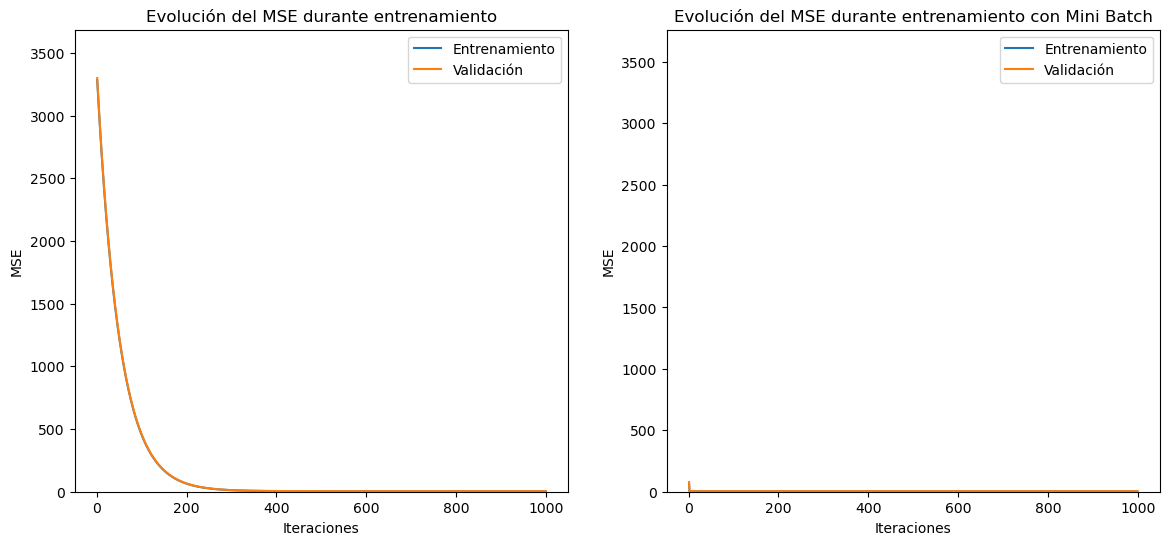

In [53]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_mse_history)), train_mse_history[1:], label='Entrenamiento')
plt.plot(range(1, len(valid_mse_history)), valid_mse_history[1:], label='Validación')
plt.xlabel('Iteraciones')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante entrenamiento')
plt.ylim(0, max(train_mse_history)*1.1)
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, len(mb_train_mse_history)), mb_train_mse_history[1:], label='Entrenamiento')
plt.plot(range(1, len(mb_valid_mse_history)), mb_valid_mse_history[1:], label='Validación')
plt.xlabel('Iteraciones')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante entrenamiento con Mini Batch')
plt.ylim(0, max(mb_train_mse_history)*1.1)
plt.legend()
plt.show()

Se puede notar que el conjunto de validación y el de entrenamiento no camian mucho entre ellos, indicando que no hay sesgo y además hay un error bastante bajo.

In [56]:
test_mse = compute_mse(X_test_norm, y_test, theta)
mb_test_mse = compute_mse(X_test_norm, y_test, mb_theta)
print(f'El MSE final del modelo con respecto al conjunto de prueba es de {test_mse}')
print(f'El MSE final del modelo (mini batch) con respecto al conjunto de prueba es de {mb_test_mse}')

El MSE final del modelo con respecto al conjunto de prueba es de 4.109668788539003
El MSE final del modelo (mini batch) con respecto al conjunto de prueba es de 4.180031297601153


In [55]:
# Predicciones sobre todo el dataset (o sobre train/valid más adelante)
y_pred = X_test_norm.dot(theta)

# Mostrar primeros 10 valores reales vs predichos
comparison = pd.DataFrame({"Actual": y_test.flatten(), "Predicho": y_pred.flatten()})
comparison.head(10)

,Actual,Predicho
0,18.0,14.882656
1,17.0,19.591067
2,11.0,13.990475
3,16.0,19.661682
4,19.0,18.618523
5,20.0,19.420693
6,18.0,20.605021
7,11.0,13.694531
8,19.0,20.979765
9,16.0,16.098462
